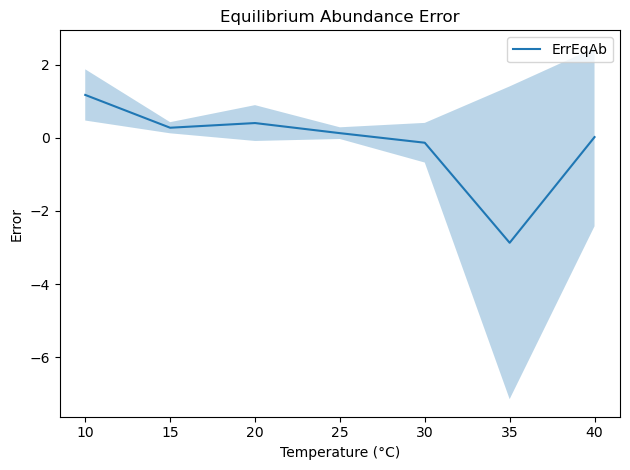

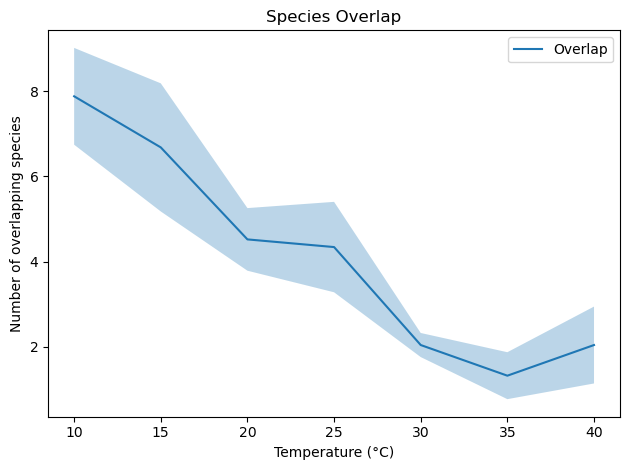

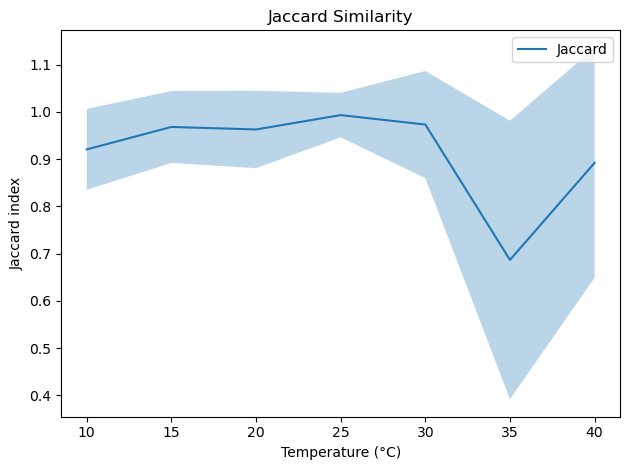

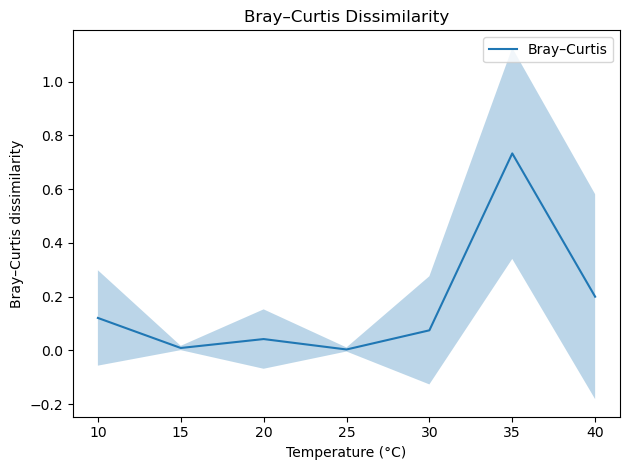

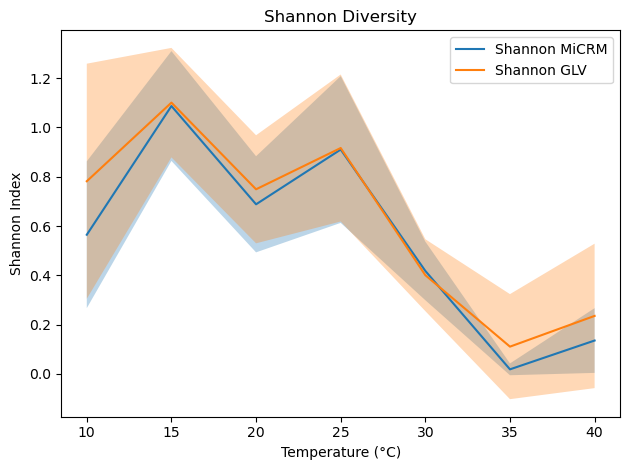

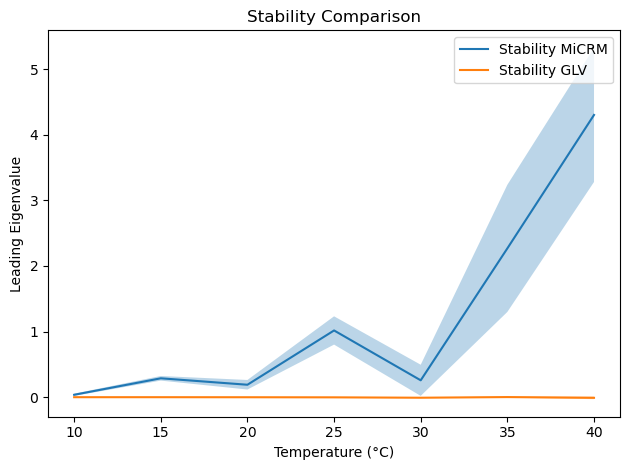

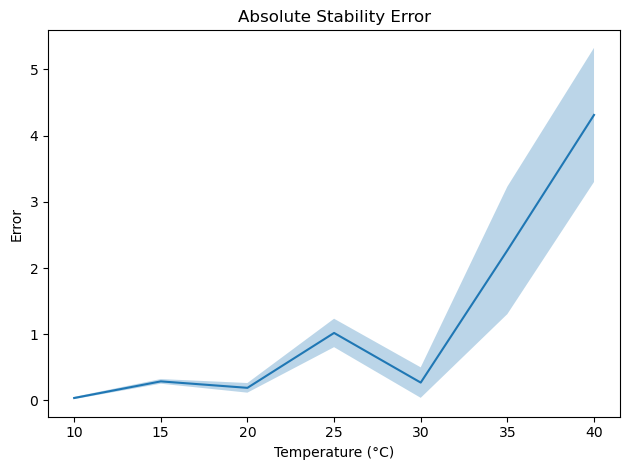

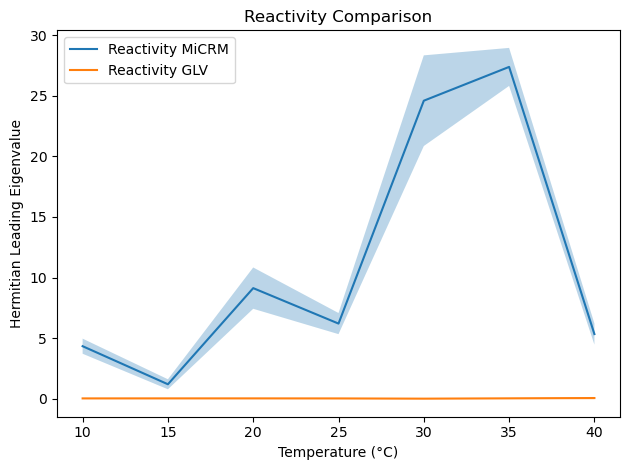

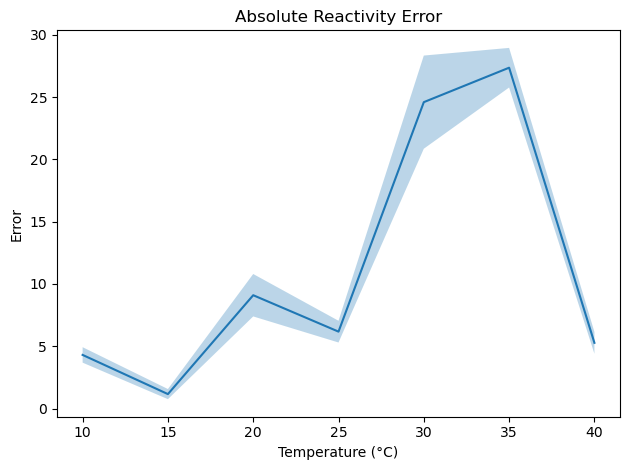

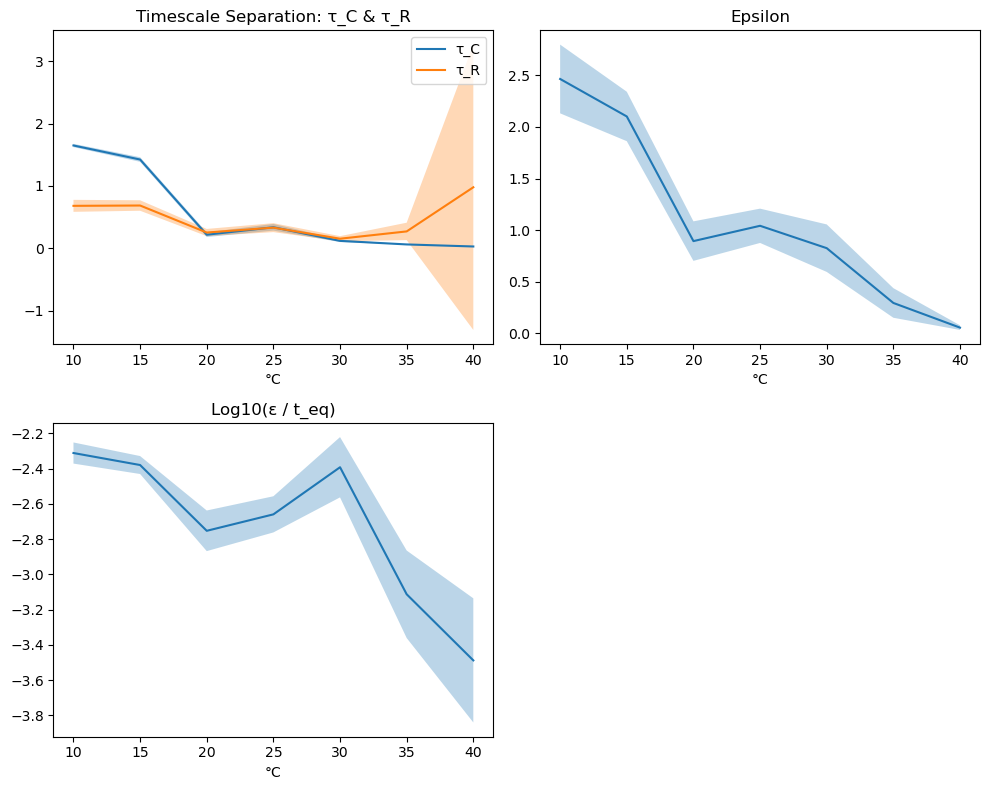

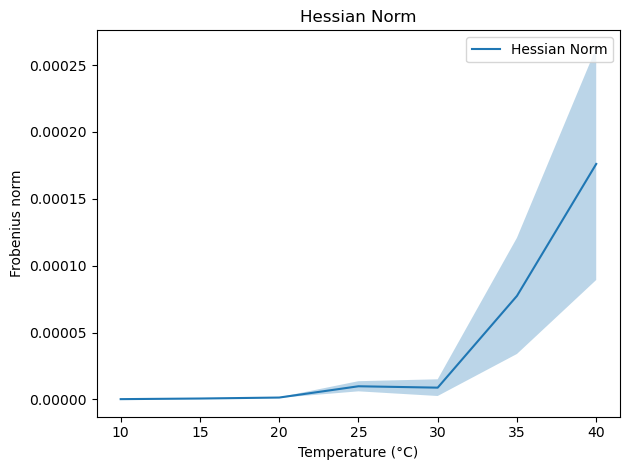

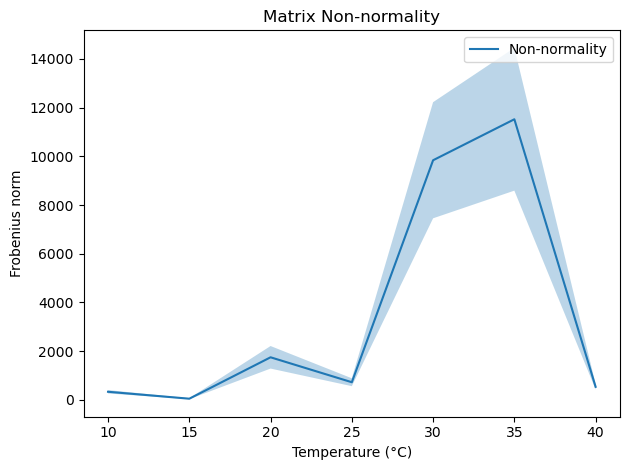

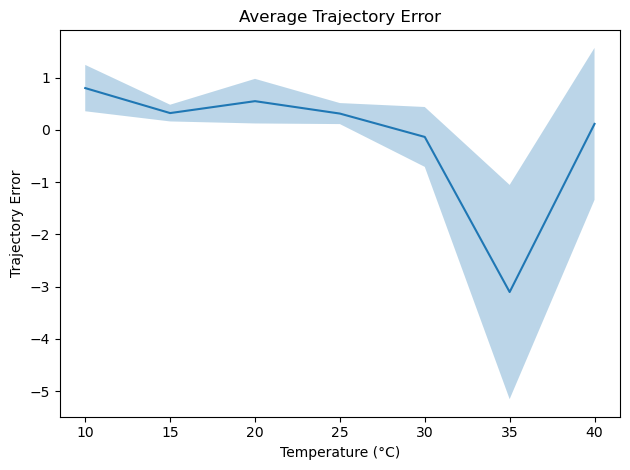

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# ─── USER: adjust these paths to point to your CSVs ─────────────────────────
metrics_fp = "output/metrics_100.csv"
raw_fp     = "output/raw_eq_100.csv"
traj_fp    = "output/traj_100.csv"

# ─── Read in data ───────────────────────────────────────────────────────────
df_met  = pd.read_csv(metrics_fp)
df_raw  = pd.read_csv(raw_fp)
df_traj = pd.read_csv(traj_fp)

# ─── Read in metrics CSV ─────────────────────────
df_met = pd.read_csv(metrics_fp)

# ─── Convert any "(real+0j)" strings to floats ───
complex_cols = ['stab_mi', 'stab_glv', 'react_mi', 'react_glv']
for col in complex_cols:
    if col in df_met.columns:
        df_met[col] = (
            df_met[col]
            .apply(lambda x: ast.literal_eval(x).real if isinstance(x, str) and '+' in x else x)
            .astype(float)
        )


# Convert temperatures to °C
for df in (df_met, df_raw, df_traj):
    if "T_K" in df.columns:
        df["T_C"] = df["T_K"] - 273.15

# ─── Helper to compute mean & SD per T_C ────────────────────────────────────
def summarize(df, cols):
    grouped = df.groupby("T_C")[cols]
    mean = grouped.mean()
    std  = grouped.std()
    return mean, std

# ─── Plotting style function ────────────────────────────────────────────────
def plot_with_error(x, y_mean, y_std, ax, label):
    ax.plot(x, y_mean, label=label)
    ax.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.3)

def plot_mean_sd(x, mean, sd, ax, label):
    ax.plot(x, mean, label=label)
    ax.fill_between(x, mean - sd, mean + sd, alpha=0.3)

# ─── 4) ErrEqAb ─────────────────────────────────────────────────────────────
mean_e, sd_e = summarize(df_met, 'ErrEqAb')
fig, ax = plt.subplots()
plot_mean_sd(mean_e.index, mean_e, sd_e, ax, 'ErrEqAb')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Error')
ax.set_title('Equilibrium Abundance Error')
ax.legend()
fig.tight_layout()

# ─── 5) Species overlap ─────────────────────────────────────────────────────
mean_o, sd_o = summarize(df_met, 'overlap')
fig, ax = plt.subplots()
plot_mean_sd(mean_o.index, mean_o, sd_o, ax, 'Overlap')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Number of overlapping species')
ax.set_title('Species Overlap')
ax.legend()
fig.tight_layout()

# ─── 6) Jaccard index ───────────────────────────────────────────────────────
mean_j, sd_j = summarize(df_met, 'jaccard')
fig, ax = plt.subplots()
plot_mean_sd(mean_j.index, mean_j, sd_j, ax, 'Jaccard')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Jaccard index')
ax.set_title('Jaccard Similarity')
ax.legend()
fig.tight_layout()

# ─── 7) Bray–Curtis dissimilarity ───────────────────────────────────────────
mean_bc, sd_bc = summarize(df_met, 'bray_curtis')
fig, ax = plt.subplots()
plot_mean_sd(mean_bc.index, mean_bc, sd_bc, ax, 'Bray–Curtis')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Bray–Curtis dissimilarity')
ax.set_title('Bray–Curtis Dissimilarity')
ax.legend()
fig.tight_layout()

# ─── 3) Shannon diversity (MiCRM vs GLV) ─────────────────────────────────────
mean, std = summarize(df_met, ["shannon_mi", "shannon_lv"])
fig, ax = plt.subplots()
plot_with_error(mean.index, mean["shannon_mi"], std["shannon_mi"], ax, "Shannon MiCRM")
plot_with_error(mean.index, mean["shannon_lv"], std["shannon_lv"], ax, "Shannon GLV")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Shannon Index")
ax.set_title("Shannon Diversity")
ax.legend()
fig.tight_layout()

# ─── 4) Stability (leading eigenvalue) & abs error ───────────────────────────
mean, std = summarize(df_met, ["stab_glv", "stab_mi", "abs_stab_err"])
fig, ax = plt.subplots()
plot_with_error(mean.index, mean["stab_mi"], std["stab_mi"], ax, "Stability MiCRM")
plot_with_error(mean.index, mean["stab_glv"], std["stab_glv"], ax, "Stability GLV")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Leading Eigenvalue")
ax.set_title("Stability Comparison")
ax.legend()
fig.tight_layout()

# ─── 5) Abs stability error ─────────────────────────────────────────────────
fig, ax = plt.subplots()
plot_with_error(mean.index, mean["abs_stab_err"], std["abs_stab_err"], ax, "Abs Stability Error")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Error")
ax.set_title("Absolute Stability Error")
fig.tight_layout()

# ─── 6) Reactivity & abs error ───────────────────────────────────────────────
mean, std = summarize(df_met, ["react_mi", "react_glv", "abs_react_err"])
fig, ax = plt.subplots()
plot_with_error(mean.index, mean["react_mi"], std["react_mi"], ax, "Reactivity MiCRM")
plot_with_error(mean.index, mean["react_glv"], std["react_glv"], ax, "Reactivity GLV")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Hermitian Leading Eigenvalue")
ax.set_title("Reactivity Comparison")
ax.legend()
fig.tight_layout()

fig, ax = plt.subplots()
plot_with_error(mean.index, mean["abs_react_err"], std["abs_react_err"], ax, "Abs Reactivity Error")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Error")
ax.set_title("Absolute Reactivity Error")
fig.tight_layout()

# ─── 7) Timescale separation: τ_C vs τ_R & ε & log10(ε/t_eq) ─────────────────
mean, std = summarize(df_met, ["tau_C", "tau_R", "epsilon", "log10_eps_t_eq"])
fig, axes = plt.subplots(2, 2, figsize=(10,8))
axs = axes.ravel()

plot_with_error(mean.index, mean["tau_C"], std["tau_C"], axs[0], "τ_C")
plot_with_error(mean.index, mean["tau_R"], std["tau_R"], axs[0], "τ_R")
axs[0].set_title("Timescale Separation: τ_C & τ_R")
axs[0].set_xlabel("°C")
axs[0].legend()

plot_with_error(mean.index, mean["epsilon"], std["epsilon"], axs[1], "ε")
axs[1].set_title("Epsilon")
axs[1].set_xlabel("°C")

plot_with_error(mean.index, mean["log10_eps_t_eq"], std["log10_eps_t_eq"], axs[2], "log₁₀(ε / t_eq)")
axs[2].set_title("Log10(ε / t_eq)")
axs[2].set_xlabel("°C")

# remove empty
fig.delaxes(axs[3])
fig.tight_layout()

# ─── 8) Hessian norm ────────────────────────────────────────────────────────
mean_h, sd_h = summarize(df_met, 'hessian_norm')
fig, ax = plt.subplots()
plot_mean_sd(mean_h.index, mean_h, sd_h, ax, 'Hessian Norm')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Frobenius norm')
ax.set_title('Hessian Norm')
ax.legend()
fig.tight_layout()

# ─── 9) Non-normality ───────────────────────────────────────────────────────
mean_nn, sd_nn = summarize(df_met, 'non_normality')
fig, ax = plt.subplots()
plot_mean_sd(mean_nn.index, mean_nn, sd_nn, ax, 'Non-normality')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Frobenius norm')
ax.set_title('Matrix Non-normality')
ax.legend()
fig.tight_layout()

# ─── 9) Trajectory error (ErrTraj) ───────────────────────────────────────────
mean_traj, std_traj = summarize(df_traj, ["ErrTraj"])
fig, ax = plt.subplots()
plot_with_error(mean_traj.index, mean_traj["ErrTraj"], std_traj["ErrTraj"], ax, "ErrTraj")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Trajectory Error")
ax.set_title("Average Trajectory Error")
fig.tight_layout()

# ─── Finally, show all figures ───────────────────────────────────────────────
plt.show()


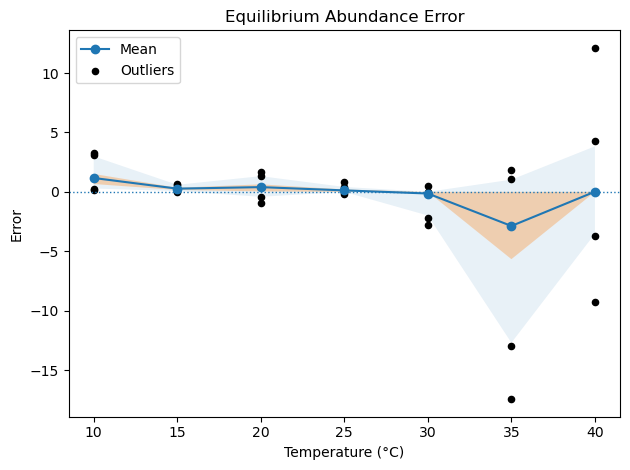

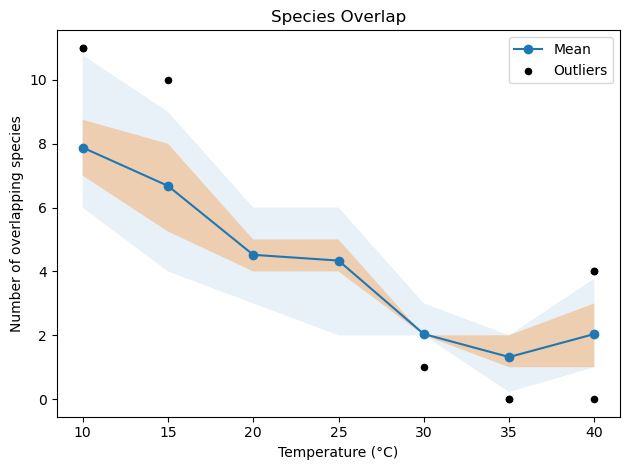

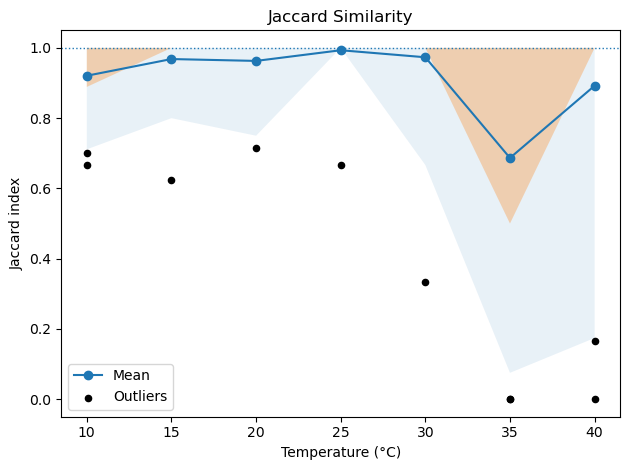

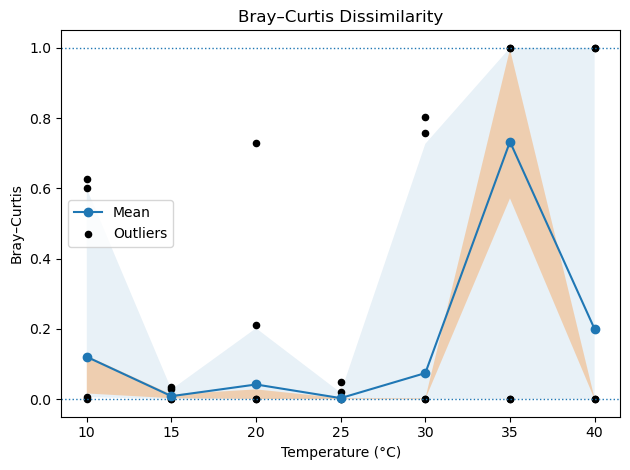

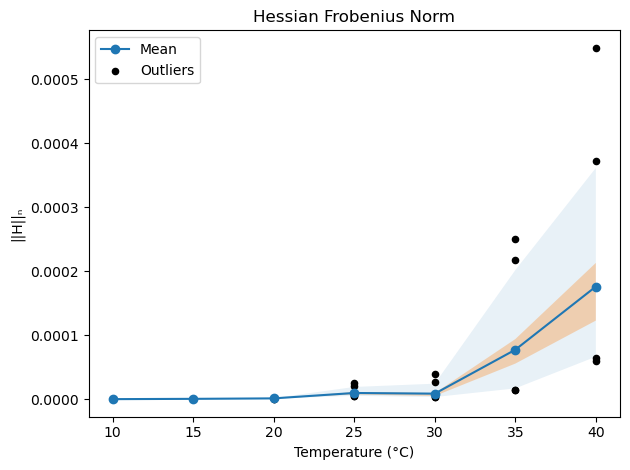

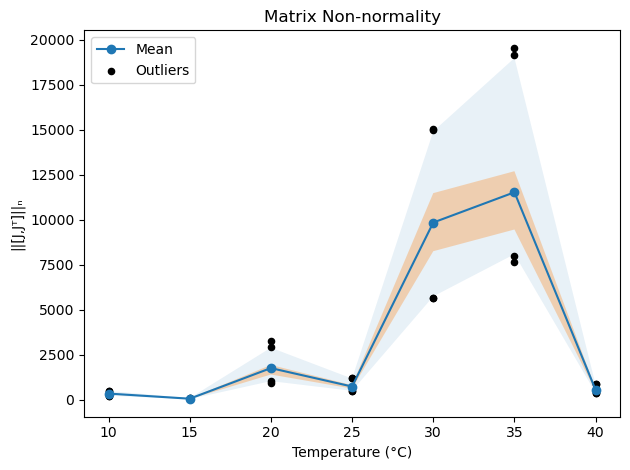

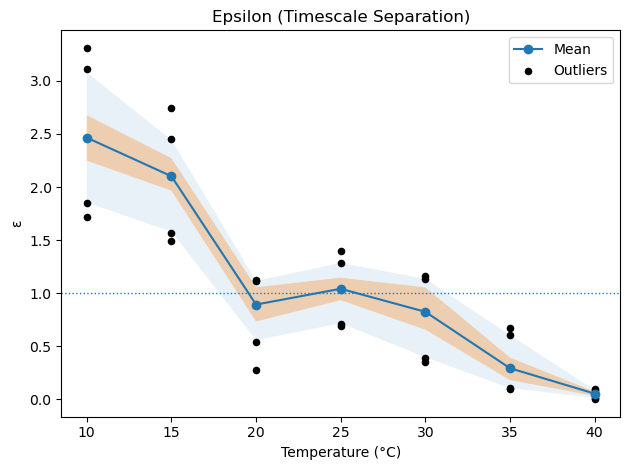

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# ─── 1) Read & clean ─────────────────────────────────────────────────────────
metrics_fp = "output/metrics_100.csv"

df = pd.read_csv(metrics_fp)
# parse any "(real+0j)" strings → real floats
for col in ['stab_mi','stab_glv','react_mi','react_glv']:
    if col in df:
        df[col] = (df[col]
            .apply(lambda x: ast.literal_eval(x).real if isinstance(x,str) and '+' in x else x)
            .astype(float)
        )
# Celsius
df['T_C'] = df['T_K'] - 273.15

# ─── 2) Stats helper ─────────────────────────────────────────────────────────
def get_stats(series):
    """Given a pd.Series, return mean, p25, p75, p025, p975, and outliers."""
    mean = series.mean()
    p25, p75 = series.quantile([0.25,0.75])
    p025, p975 = series.quantile([0.025,0.975])
    return mean, p25, p75, p025, p975

# ─── 3) Universal plot function ──────────────────────────────────────────────
def plot_metric(df, col, title, ylabel, hlines=None, hline=None):
    """
    df: dataframe with 'T_C' and col
    col: metric column name
    title: plot title
    ylabel: y-axis label
    hline: single y-value for dotted reference
    hlines: list of y-values for multiple dotted references
    """
    temps = sorted(df['T_C'].unique())
    means, i25, i75, l95, u95 = [], [], [], [], []
    out_x, out_y = [], []
    for T in temps:
        vals = df.loc[df['T_C']==T, col]
        m,p25,p75,p025,p975 = get_stats(vals)
        means.append(m); i25.append(p25); i75.append(p75); l95.append(p025); u95.append(p975)
        # collect outliers
        mask = (vals < p025) | (vals > p975)
        out_x.extend([T]*mask.sum())
        out_y.extend(vals[mask])

    fig, ax = plt.subplots()
    # 95% band
    ax.fill_between(temps, l95, u95, alpha=0.1)
    # IQR band
    ax.fill_between(temps, i25, i75, alpha=0.3)
    # mean + dots
    ax.plot(temps, means, '-o', label='Mean')
    # outliers
    if out_x:
        ax.scatter(out_x, out_y, c='k', s=20, label='Outliers')

    # reference lines
    if hline is not None:
        ax.axhline(hline, linestyle=':', linewidth=1)
    if hlines:
        for y in hlines:
            ax.axhline(y, linestyle=':', linewidth=1)

    ax.set_title(title)
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.tight_layout()

# ─── 4) Call for each metric ──────────────────────────────────────────────────
plot_metric(df, 'ErrEqAb',
            title='Equilibrium Abundance Error',
            ylabel='Error',
            hline=0)

plot_metric(df, 'overlap',
            title='Species Overlap',
            ylabel='Number of overlapping species')

plot_metric(df, 'jaccard',
            title='Jaccard Similarity',
            ylabel='Jaccard index',
            hline=1.0)

plot_metric(df, 'bray_curtis',
            title='Bray–Curtis Dissimilarity',
            ylabel='Bray–Curtis',
            hlines=[0,1])

plot_metric(df, 'hessian_norm',
            title='Hessian Frobenius Norm',
            ylabel='||H||ₙ')

plot_metric(df, 'non_normality',
            title='Matrix Non-normality',
            ylabel='||[J,Jᵀ]||ₙ')

plot_metric(df, 'epsilon',
            title='Epsilon (Timescale Separation)',
            ylabel='ε',
            hline=1.0)

# ─── 5) Show all ─────────────────────────────────────────────────────────────
plt.show()


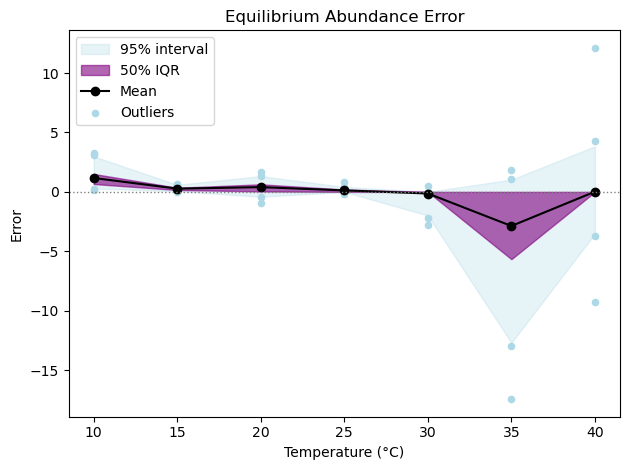

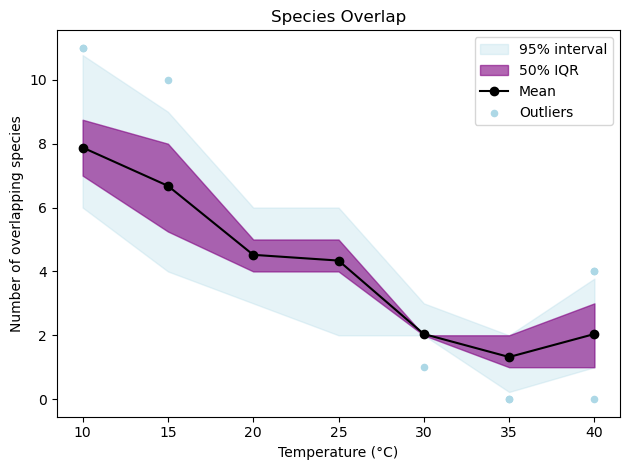

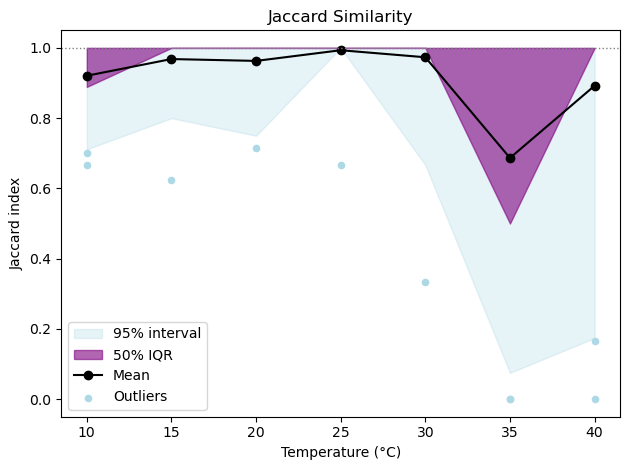

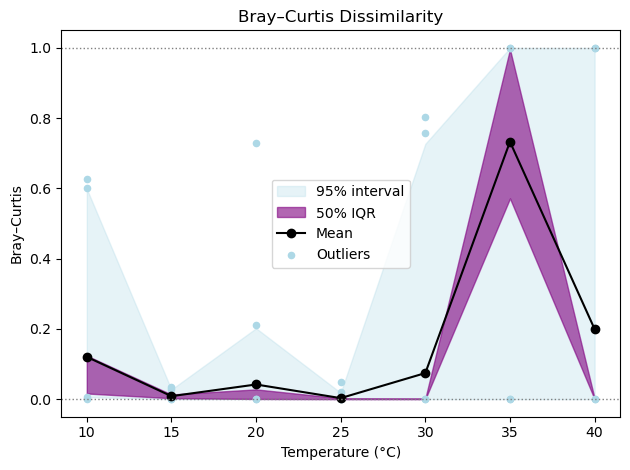

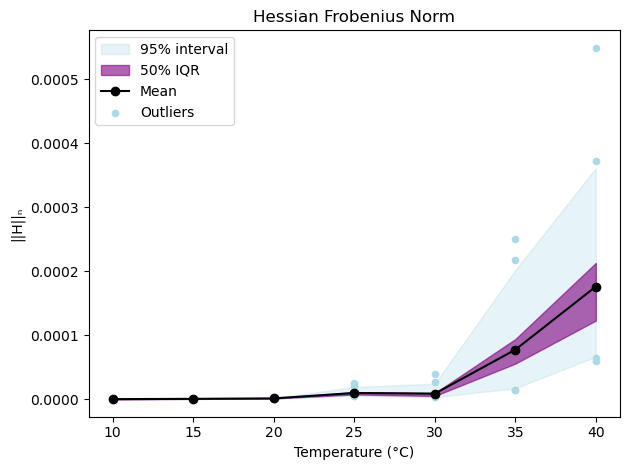

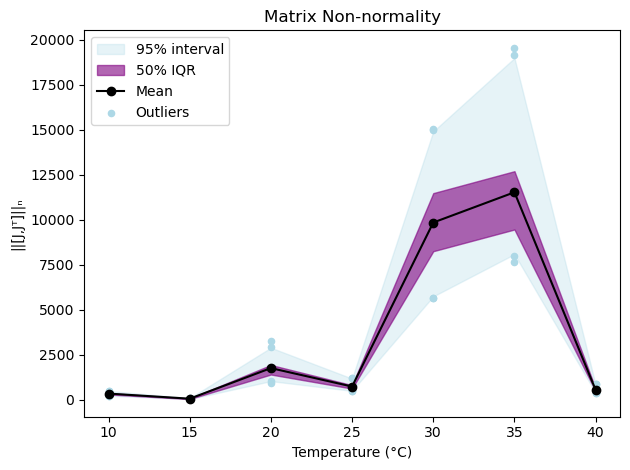

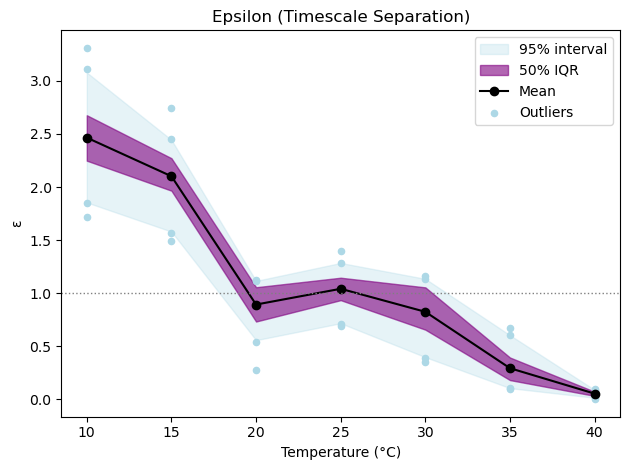

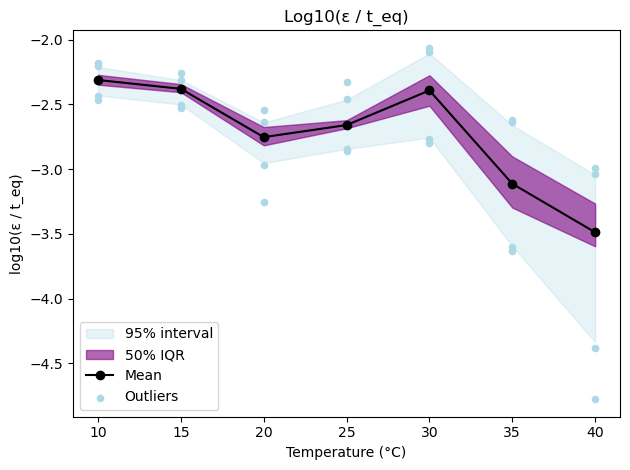

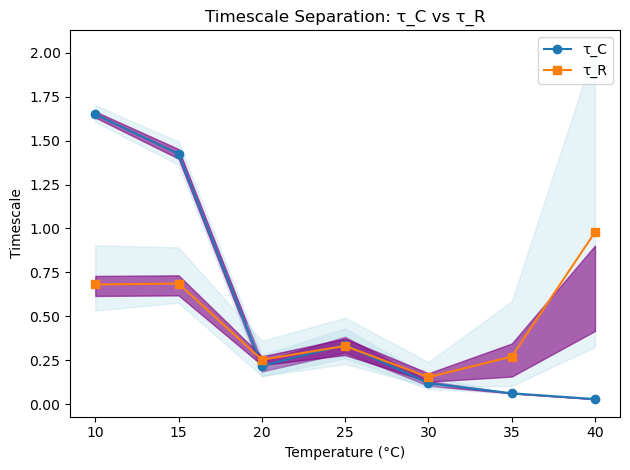

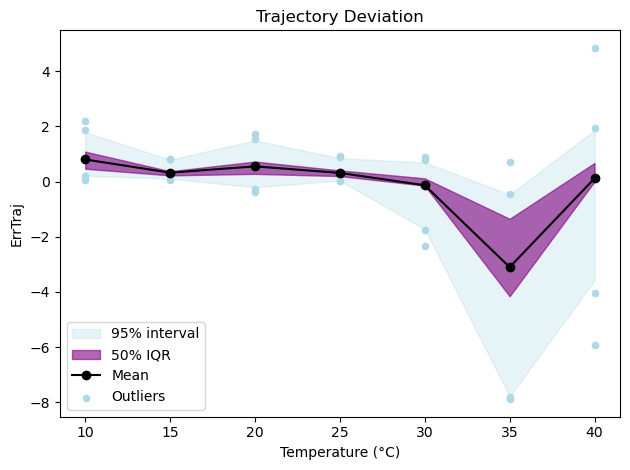

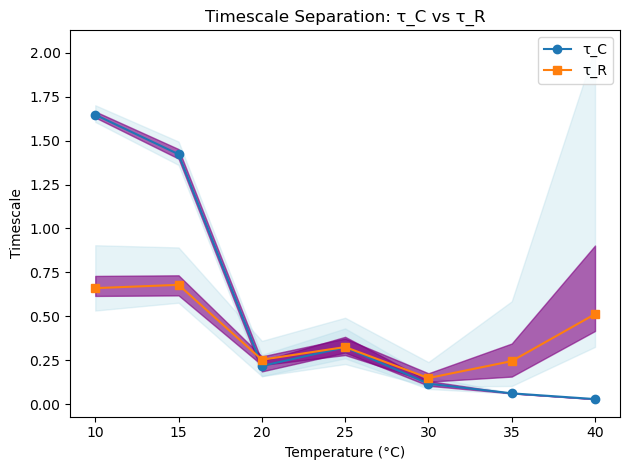

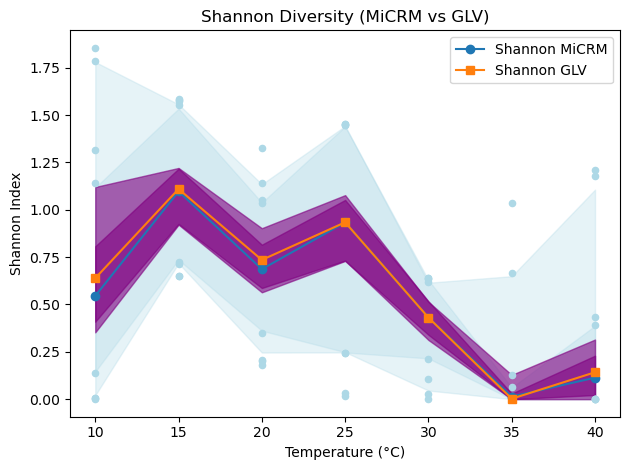

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# ─── 1) Read & clean ─────────────────────────────────────────────────────────
metrics_fp = "output/metrics_100.csv"
traj_fp    = "output/traj_100.csv"

df = pd.read_csv(metrics_fp)
# parse any "(real+0j)" strings → real floats
for col in ['stab_mi','stab_glv','react_mi','react_glv']:
    if col in df:
        df[col] = (df[col]
            .apply(lambda x: ast.literal_eval(x).real if isinstance(x,str) and '+' in x else x)
            .astype(float)
        )
df['T_C'] = df['T_K'] - 273.15

df_traj = pd.read_csv(traj_fp)
df_traj['T_C'] = df_traj['T_K'] - 273.15

# ─── 2) Stats helper ─────────────────────────────────────────────────────────
def get_stats(series):
    mean = series.mean()
    p25, p75 = series.quantile([0.25,0.75])
    p025, p975 = series.quantile([0.025,0.975])
    return mean, p25, p75, p025, p975

# ─── 3) Universal plot function ──────────────────────────────────────────────
def plot_metric(df, col, title, ylabel, hlines=None, hline=None):
    temps = sorted(df['T_C'].unique())
    means, p25s, p75s, low95s, hi95s = [], [], [], [], []
    out_x, out_y = [], []
    for T in temps:
        vals = df[df['T_C']==T][col]
        m, p25, p75, l95, u95 = get_stats(vals)
        means.append(m); p25s.append(p25); p75s.append(p75)
        low95s.append(l95); hi95s.append(u95)
        mask = (vals < l95) | (vals > u95)
        out_x.extend([T]*mask.sum())
        out_y.extend(vals[mask])

    # color scheme
    c50, c95 = 'purple', 'lightblue'

    fig, ax = plt.subplots()
    ax.fill_between(temps, low95s, hi95s, color=c95, alpha=0.3, label='95% interval')
    ax.fill_between(temps, p25s, p75s, color=c50, alpha=0.6, label='50% IQR')
    ax.plot(temps, means, '-o', color='k', label='Mean')
    if out_x:
        ax.scatter(out_x, out_y, color=c95, s=20, label='Outliers')

    # reference lines
    if hline is not None:
        ax.axhline(hline, linestyle=':', linewidth=1, color='gray')
    if hlines:
        for y in hlines:
            ax.axhline(y, linestyle=':', linewidth=1, color='gray')

    ax.set_title(title)
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.tight_layout()

# ─── 4) Individual plots ─────────────────────────────────────────────────────
plot_metric(df, 'ErrEqAb',
            title='Equilibrium Abundance Error',
            ylabel='Error',
            hline=0)

plot_metric(df, 'overlap',
            title='Species Overlap',
            ylabel='Number of overlapping species')

plot_metric(df, 'jaccard',
            title='Jaccard Similarity',
            ylabel='Jaccard index',
            hline=1.0)

plot_metric(df, 'bray_curtis',
            title='Bray–Curtis Dissimilarity',
            ylabel='Bray–Curtis',
            hlines=[0,1])

plot_metric(df, 'hessian_norm',
            title='Hessian Frobenius Norm',
            ylabel='||H||ₙ')

plot_metric(df, 'non_normality',
            title='Matrix Non-normality',
            ylabel='||[J,Jᵀ]||ₙ')

plot_metric(df, 'epsilon',
            title='Epsilon (Timescale Separation)',
            ylabel='ε',
            hline=1.0)

plot_metric(df, 'log10_eps_t_eq',
            title='Log10(ε / t_eq)',
            ylabel='log10(ε / t_eq)')

# tau_C vs tau_R
temps = sorted(df['T_C'].unique())
tauC_mean, tauC_p25, tauC_p75, tauC_l95, tauC_u95 = zip(*[get_stats(df[df['T_C']==T]['tau_C']) for T in temps])
tauR_mean, tauR_p25, tauR_p75, tauR_l95, tauR_u95 = zip(*[get_stats(df[df['T_C']==T]['tau_R']) for T in temps])

fig, ax = plt.subplots()
ax.fill_between(temps, tauC_l95, tauC_u95, color='lightblue', alpha=0.3)
ax.fill_between(temps, tauC_p25, tauC_p75, color='purple', alpha=0.6)
ax.plot(temps, tauC_mean, '-o', label='τ_C')

ax.fill_between(temps, tauR_l95, tauR_u95, color='lightblue', alpha=0.3)
ax.fill_between(temps, tauR_p25, tauR_p75, color='purple', alpha=0.6)
ax.plot(temps, tauR_mean, '-s', label='τ_R')

ax.set_title('Timescale Separation: τ_C vs τ_R')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Timescale')
ax.legend()
fig.tight_layout()

# trajectory deviation
plot_metric(df_traj, 'ErrTraj',
            title='Trajectory Deviation',
            ylabel='ErrTraj')

# ─── 5) Show all ─────────────────────────────────────────────────────────────
plt.show()

def plot_tau_C_vs_tau_R(df):
    temps = sorted(df['T_C'].unique())
    
    # Compute median, IQR (25–75%), and 95% bounds for a column
    def stats(col):
        q = df.groupby('T_C')[col].quantile([0.5, 0.25, 0.75, 0.025, 0.975]).unstack()
        return q[0.5].values, q[0.25].values, q[0.75].values, q[0.025].values, q[0.975].values

    mC, p25C, p75C, l95C, u95C = stats('tau_C')
    mR, p25R, p75R, l95R, u95R = stats('tau_R')

    fig, ax = plt.subplots()
    # 95% confidence bands
    ax.fill_between(temps, l95C, u95C, color='lightblue', alpha=0.3)
    ax.fill_between(temps, l95R, u95R, color='lightblue', alpha=0.3)
    # 50% IQR bands
    ax.fill_between(temps, p25C, p75C, color='purple', alpha=0.6)
    ax.fill_between(temps, p25R, p75R, color='purple', alpha=0.6)
    # Median lines + markers
    ax.plot(temps, mC, '-o', label='τ_C')
    ax.plot(temps, mR, '-s', label='τ_R')

    ax.set_title('Timescale Separation: τ_C vs τ_R')
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Timescale')
    ax.legend()
    fig.tight_layout()
    plt.show()

# Then simply call:
plot_tau_C_vs_tau_R(df)


def plot_shannon_diversity(df):
    """
    Overlay Shannon diversity for MiCRM vs GLV:
    - Mean ±50% IQR (purple)
    - Mean ±95% interval (light blue)
    - Mean line + markers
    - Outliers in light blue
    """
    temps = sorted(df['T_C'].unique())
    def stats(col):
        q = df.groupby('T_C')[col].quantile([0.5, 0.25, 0.75, 0.025, 0.975]).unstack()
        return q[0.5].values, q[0.25].values, q[0.75].values, q[0.025].values, q[0.975].values

    # Compute stats
    m_mi, p25_mi, p75_mi, l95_mi, u95_mi = stats('shannon_mi')
    m_lv, p25_lv, p75_lv, l95_lv, u95_lv = stats('shannon_lv')

    fig, ax = plt.subplots()
    # 95% bands
    ax.fill_between(temps, l95_mi, u95_mi, color='lightblue', alpha=0.3)
    ax.fill_between(temps, l95_lv, u95_lv, color='lightblue', alpha=0.3)
    # 50% IQR bands
    ax.fill_between(temps, p25_mi, p75_mi, color='purple', alpha=0.6)
    ax.fill_between(temps, p25_lv, p75_lv, color='purple', alpha=0.6)
    # Mean lines + markers
    ax.plot(temps, m_mi, '-o', label='Shannon MiCRM')
    ax.plot(temps, m_lv, '-s', label='Shannon GLV')
    # Outliers
    for col, l95, u95 in [('shannon_mi', l95_mi, u95_mi), ('shannon_lv', l95_lv, u95_lv)]:
        vals = df[col]
        xs, ys = [], []
        for T in temps:
            v = df[df['T_C']==T][col]
            mask = (v < df[df['T_C']==T][col].quantile(0.025)) | (v > df[df['T_C']==T][col].quantile(0.975))
            xs.extend([T]*mask.sum()); ys.extend(v[mask])
        if xs:
            ax.scatter(xs, ys, color='lightblue', s=20)

    ax.set_title('Shannon Diversity (MiCRM vs GLV)')
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Shannon Index')
    ax.legend()
    fig.tight_layout()
    plt.show()

# Call it:
plot_shannon_diversity(df)


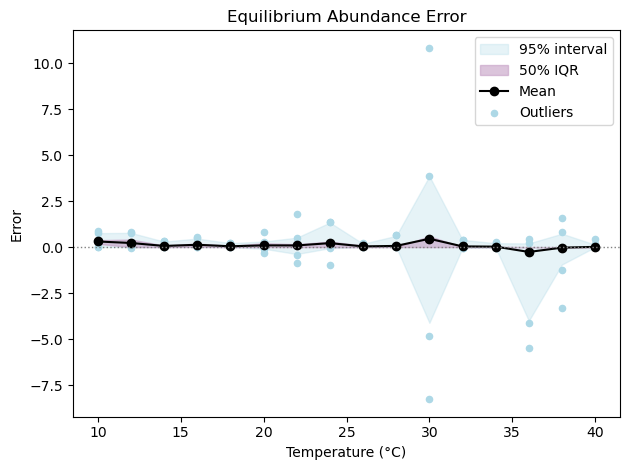

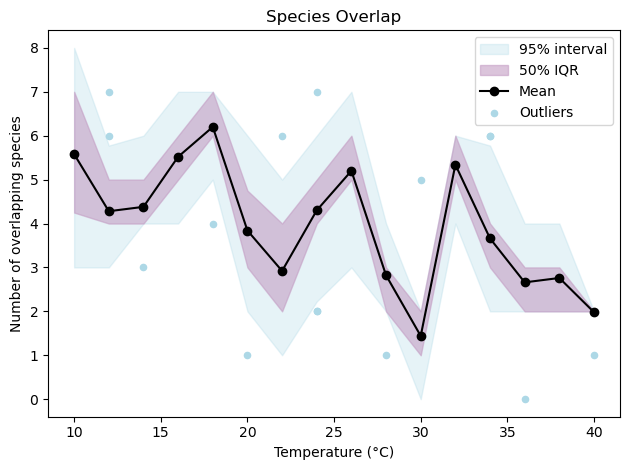

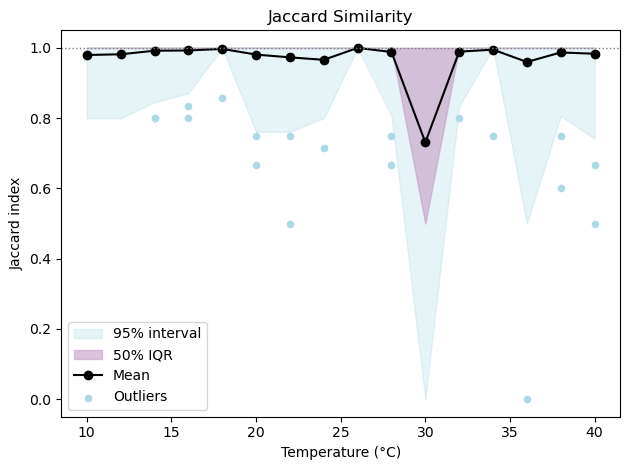

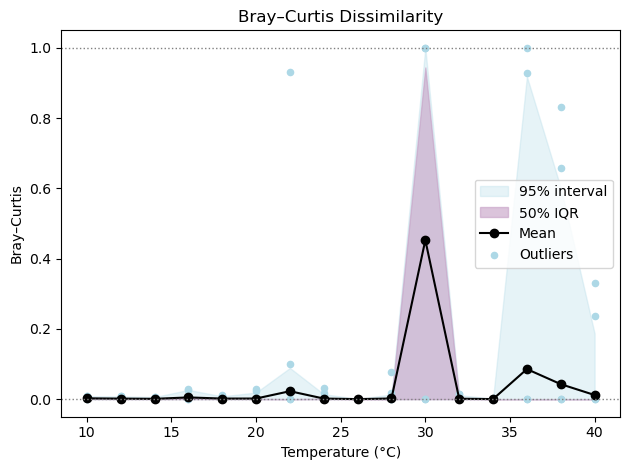

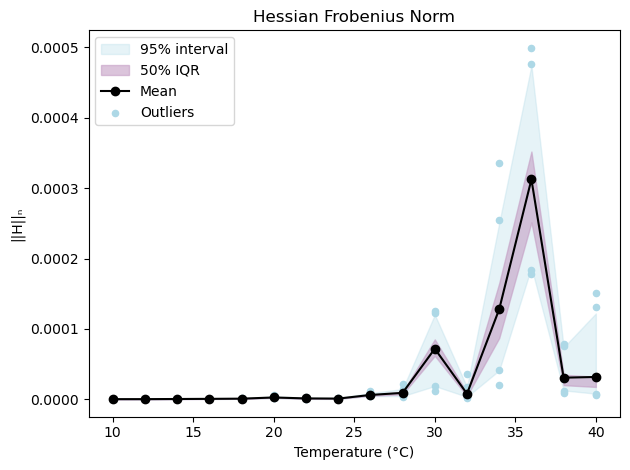

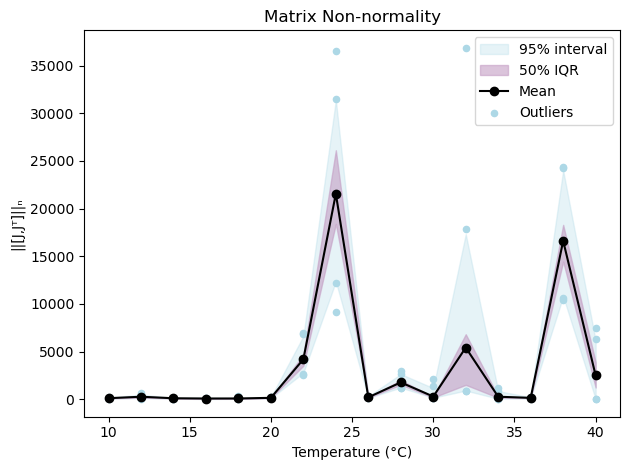

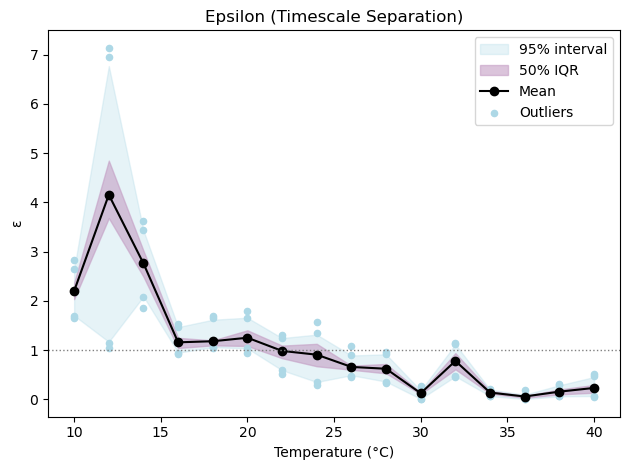

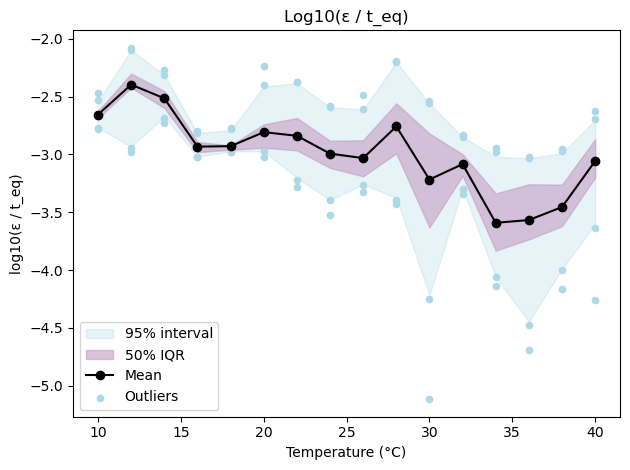

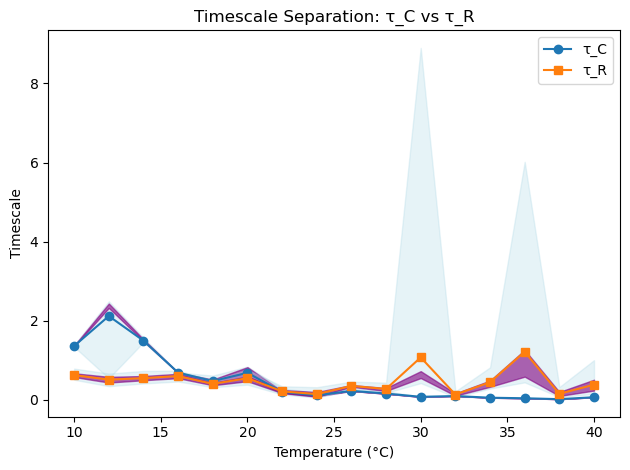

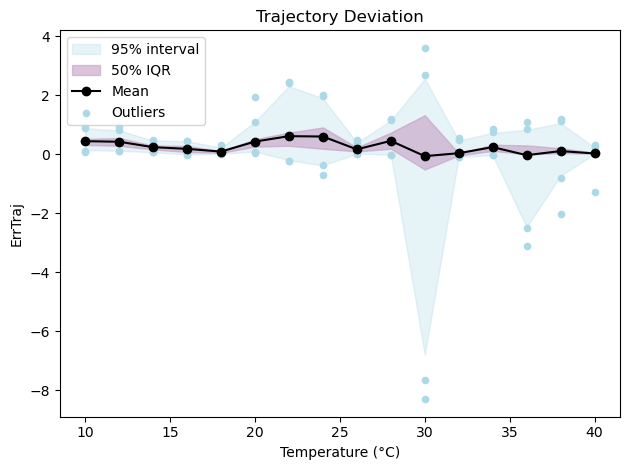

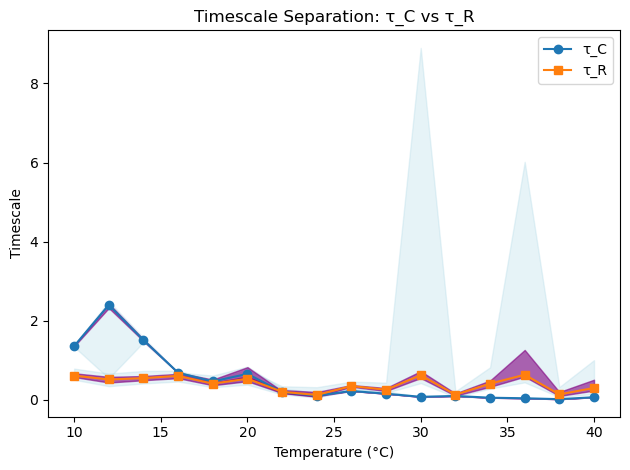

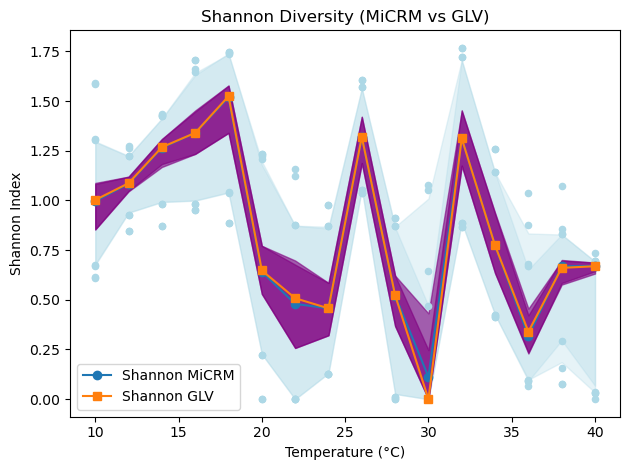

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# ─── 1) Read & clean ─────────────────────────────────────────────────────────
metrics_fp = "output/metrics_N50.csv"
traj_fp    = "output/traj_N50.csv"

df = pd.read_csv(metrics_fp)
# parse any "(real+0j)" strings → real floats
for col in ['stab_mi','stab_glv','react_mi','react_glv']:
    if col in df:
        df[col] = (df[col]
            .apply(lambda x: ast.literal_eval(x).real if isinstance(x,str) and '+' in x else x)
            .astype(float)
        )
df['T_C'] = df['T_K'] - 273.15

df_traj = pd.read_csv(traj_fp)
df_traj['T_C'] = df_traj['T_K'] - 273.15

# ─── 2) Stats helper ─────────────────────────────────────────────────────────
def get_stats(series):
    mean = series.mean()
    p25, p75 = series.quantile([0.25,0.75])
    p025, p975 = series.quantile([0.025,0.975])
    return mean, p25, p75, p025, p975

# ─── 3) Universal plot function ──────────────────────────────────────────────
def plot_metric(df, col, title, ylabel, hlines=None, hline=None):
    temps = sorted(df['T_C'].unique())
    means, p25s, p75s, low95s, hi95s = [], [], [], [], []
    out_x, out_y = [], []
    for T in temps:
        vals = df[df['T_C']==T][col]
        m, p25, p75, l95, u95 = get_stats(vals)
        means.append(m); p25s.append(p25); p75s.append(p75)
        low95s.append(l95); hi95s.append(u95)
        mask = (vals < l95) | (vals > u95)
        out_x.extend([T]*mask.sum())
        out_y.extend(vals[mask])

    # color scheme
    c50, c95 = '#c49ec4', 'lightblue'

    fig, ax = plt.subplots()
    ax.fill_between(temps, low95s, hi95s, color=c95, alpha=0.3, label='95% interval')
    ax.fill_between(temps, p25s, p75s, color=c50, alpha=0.6, label='50% IQR')
    ax.plot(temps, means, '-o', color='k', label='Mean')
    if out_x:
        ax.scatter(out_x, out_y, color=c95, s=20, label='Outliers')

    # reference lines
    if hline is not None:
        ax.axhline(hline, linestyle=':', linewidth=1, color='gray')
    if hlines:
        for y in hlines:
            ax.axhline(y, linestyle=':', linewidth=1, color='gray')

    ax.set_title(title)
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.tight_layout()

# ─── 4) Individual plots ─────────────────────────────────────────────────────
plot_metric(df, 'ErrEqAb',
            title='Equilibrium Abundance Error',
            ylabel='Error',
            hline=0)

plot_metric(df, 'overlap',
            title='Species Overlap',
            ylabel='Number of overlapping species')

plot_metric(df, 'jaccard',
            title='Jaccard Similarity',
            ylabel='Jaccard index',
            hline=1.0)

plot_metric(df, 'bray_curtis',
            title='Bray–Curtis Dissimilarity',
            ylabel='Bray–Curtis',
            hlines=[0,1])

plot_metric(df, 'hessian_norm',
            title='Hessian Frobenius Norm',
            ylabel='||H||ₙ')

plot_metric(df, 'non_normality',
            title='Matrix Non-normality',
            ylabel='||[J,Jᵀ]||ₙ')

plot_metric(df, 'epsilon',
            title='Epsilon (Timescale Separation)',
            ylabel='ε',
            hline=1.0)

plot_metric(df, 'log10_eps_t_eq',
            title='Log10(ε / t_eq)',
            ylabel='log10(ε / t_eq)')

# tau_C vs tau_R
temps = sorted(df['T_C'].unique())
tauC_mean, tauC_p25, tauC_p75, tauC_l95, tauC_u95 = zip(*[get_stats(df[df['T_C']==T]['tau_C']) for T in temps])
tauR_mean, tauR_p25, tauR_p75, tauR_l95, tauR_u95 = zip(*[get_stats(df[df['T_C']==T]['tau_R']) for T in temps])

fig, ax = plt.subplots()
ax.fill_between(temps, tauC_l95, tauC_u95, color='lightblue', alpha=0.3)
ax.fill_between(temps, tauC_p25, tauC_p75, color='purple', alpha=0.6)
ax.plot(temps, tauC_mean, '-o', label='τ_C')

ax.fill_between(temps, tauR_l95, tauR_u95, color='lightblue', alpha=0.3)
ax.fill_between(temps, tauR_p25, tauR_p75, color='purple', alpha=0.6)
ax.plot(temps, tauR_mean, '-s', label='τ_R')

ax.set_title('Timescale Separation: τ_C vs τ_R')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Timescale')
ax.legend()
fig.tight_layout()

# trajectory deviation
plot_metric(df_traj, 'ErrTraj',
            title='Trajectory Deviation',
            ylabel='ErrTraj')

# ─── 5) Show all ─────────────────────────────────────────────────────────────
plt.show()

def plot_tau_C_vs_tau_R(df):
    temps = sorted(df['T_C'].unique())
    
    # Compute median, IQR (25–75%), and 95% bounds for a column
    def stats(col):
        q = df.groupby('T_C')[col].quantile([0.5, 0.25, 0.75, 0.025, 0.975]).unstack()
        return q[0.5].values, q[0.25].values, q[0.75].values, q[0.025].values, q[0.975].values

    mC, p25C, p75C, l95C, u95C = stats('tau_C')
    mR, p25R, p75R, l95R, u95R = stats('tau_R')

    fig, ax = plt.subplots()
    # 95% confidence bands
    ax.fill_between(temps, l95C, u95C, color='lightblue', alpha=0.3)
    ax.fill_between(temps, l95R, u95R, color='lightblue', alpha=0.3)
    # 50% IQR bands
    ax.fill_between(temps, p25C, p75C, color='purple', alpha=0.6)
    ax.fill_between(temps, p25R, p75R, color='purple', alpha=0.6)
    # Median lines + markers
    ax.plot(temps, mC, '-o', label='τ_C')
    ax.plot(temps, mR, '-s', label='τ_R')

    ax.set_title('Timescale Separation: τ_C vs τ_R')
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Timescale')
    ax.legend()
    fig.tight_layout()
    plt.show()

# Then simply call:
plot_tau_C_vs_tau_R(df)


def plot_shannon_diversity(df):
    """
    Overlay Shannon diversity for MiCRM vs GLV:
    - Mean ±50% IQR (purple)
    - Mean ±95% interval (light blue)
    - Mean line + markers
    - Outliers in light blue
    """
    temps = sorted(df['T_C'].unique())
    def stats(col):
        q = df.groupby('T_C')[col].quantile([0.5, 0.25, 0.75, 0.025, 0.975]).unstack()
        return q[0.5].values, q[0.25].values, q[0.75].values, q[0.025].values, q[0.975].values

    # Compute stats
    m_mi, p25_mi, p75_mi, l95_mi, u95_mi = stats('shannon_mi')
    m_lv, p25_lv, p75_lv, l95_lv, u95_lv = stats('shannon_lv')

    fig, ax = plt.subplots()
    # 95% bands
    ax.fill_between(temps, l95_mi, u95_mi, color='lightblue', alpha=0.3)
    ax.fill_between(temps, l95_lv, u95_lv, color='lightblue', alpha=0.3)
    # 50% IQR bands
    ax.fill_between(temps, p25_mi, p75_mi, color='purple', alpha=0.6)
    ax.fill_between(temps, p25_lv, p75_lv, color='purple', alpha=0.6)
    # Mean lines + markers
    ax.plot(temps, m_mi, '-o', label='Shannon MiCRM')
    ax.plot(temps, m_lv, '-s', label='Shannon GLV')
    # Outliers
    for col, l95, u95 in [('shannon_mi', l95_mi, u95_mi), ('shannon_lv', l95_lv, u95_lv)]:
        vals = df[col]
        xs, ys = [], []
        for T in temps:
            v = df[df['T_C']==T][col]
            mask = (v < df[df['T_C']==T][col].quantile(0.025)) | (v > df[df['T_C']==T][col].quantile(0.975))
            xs.extend([T]*mask.sum()); ys.extend(v[mask])
        if xs:
            ax.scatter(xs, ys, color='lightblue', s=20)

    ax.set_title('Shannon Diversity (MiCRM vs GLV)')
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Shannon Index')
    ax.legend()
    fig.tight_layout()
    plt.show()

# Call it:
plot_shannon_diversity(df)


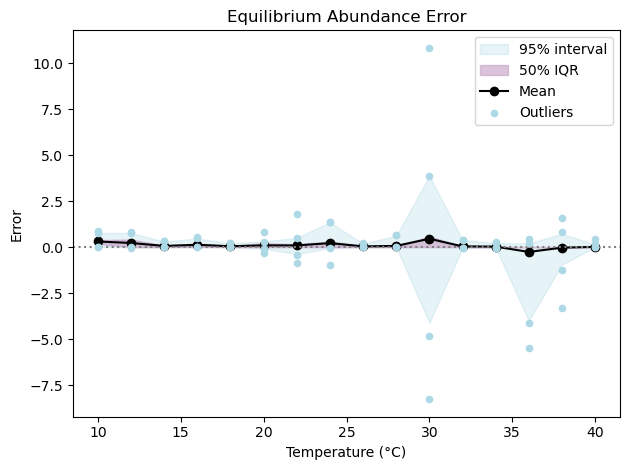

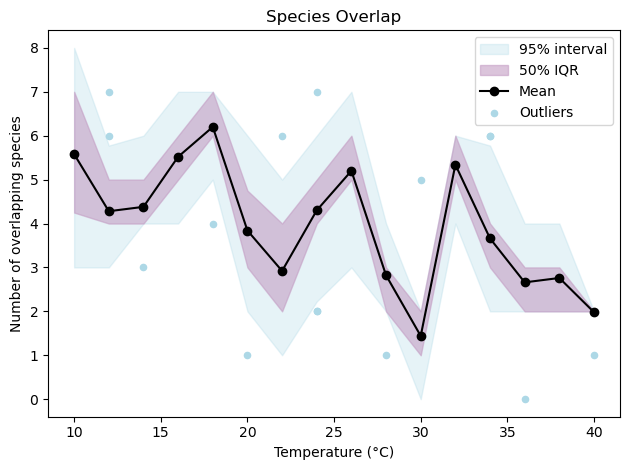

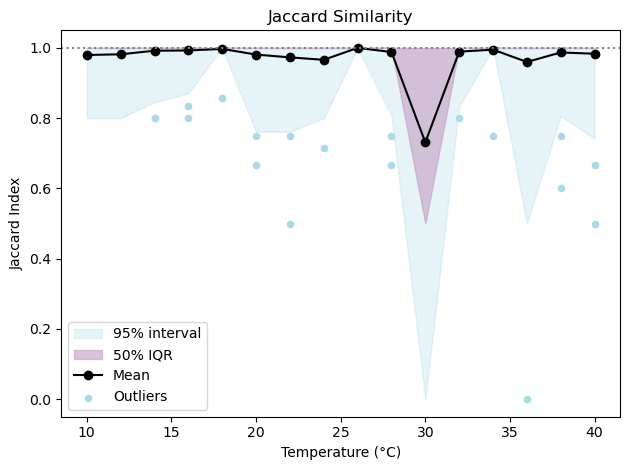

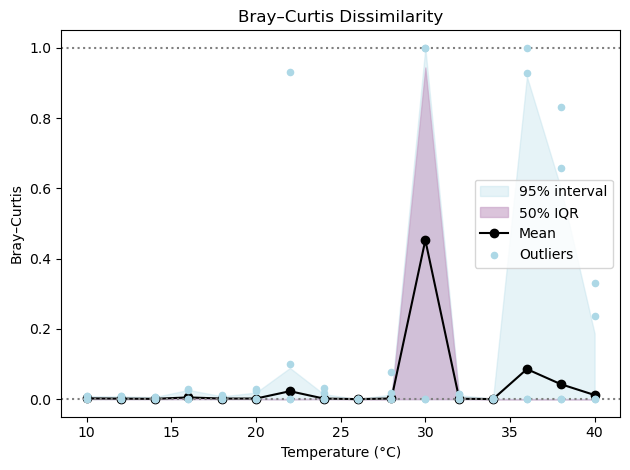

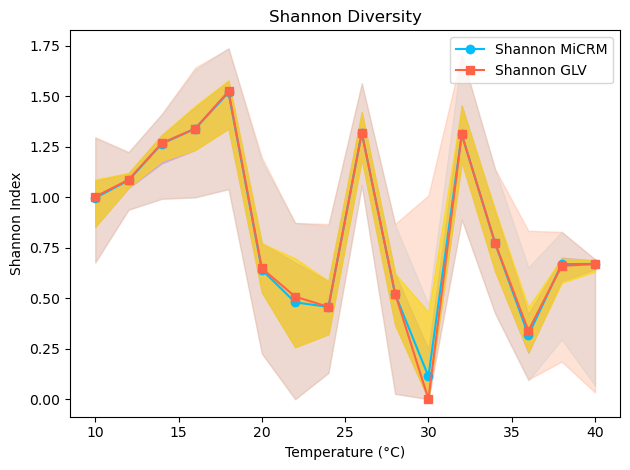

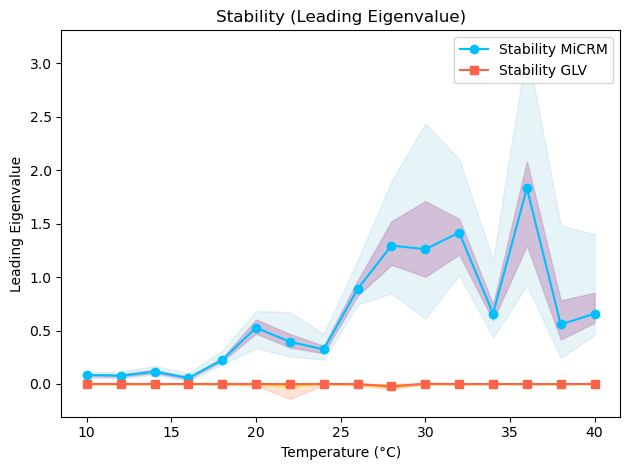

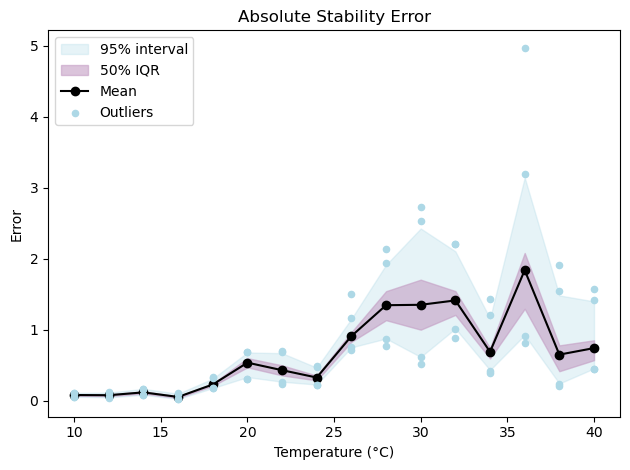

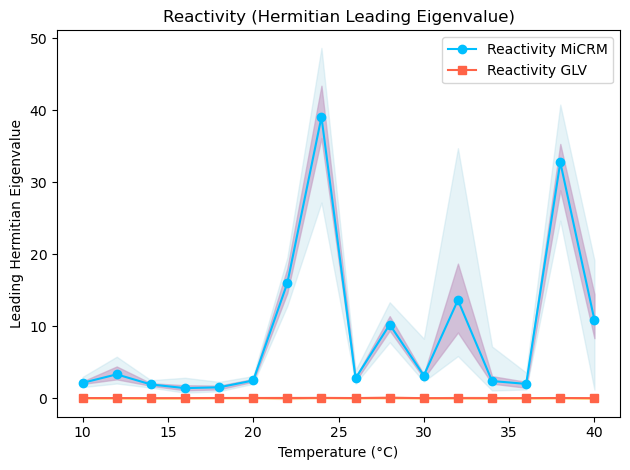

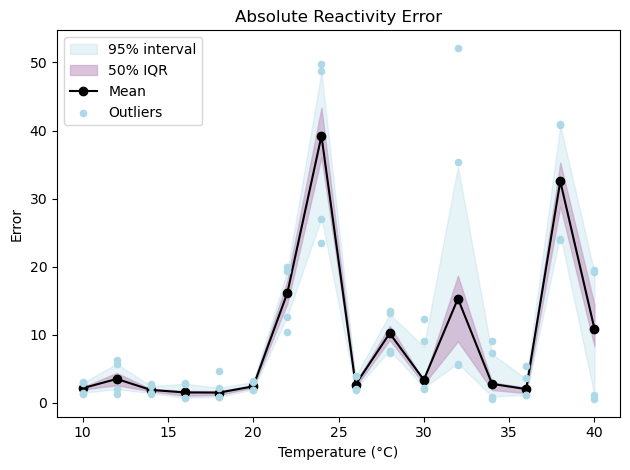

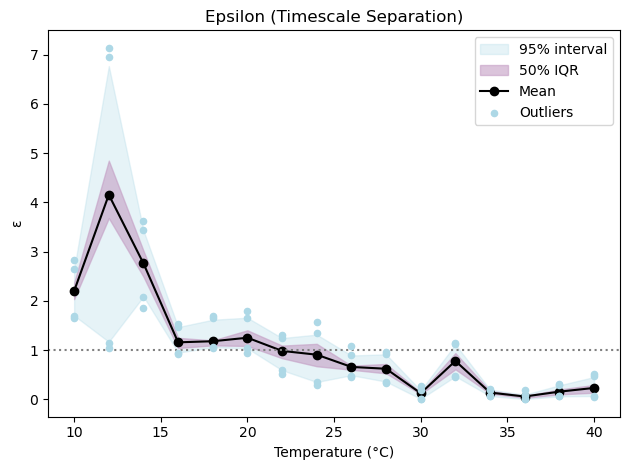

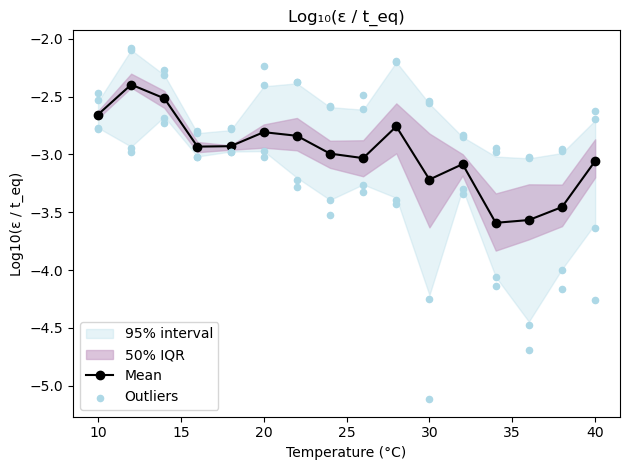

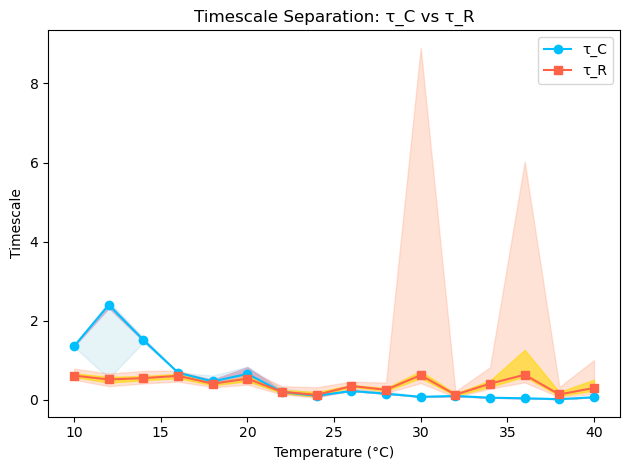

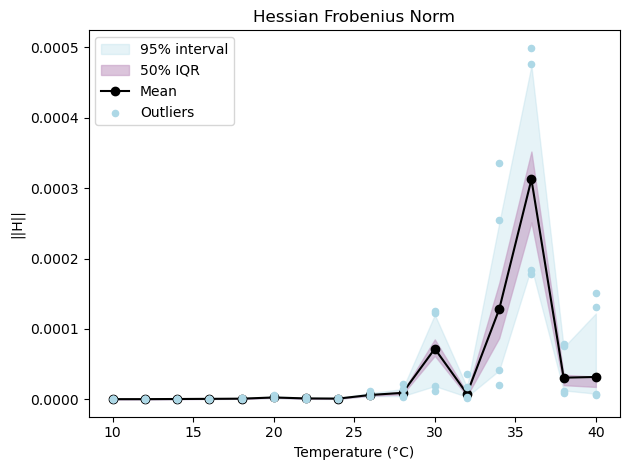

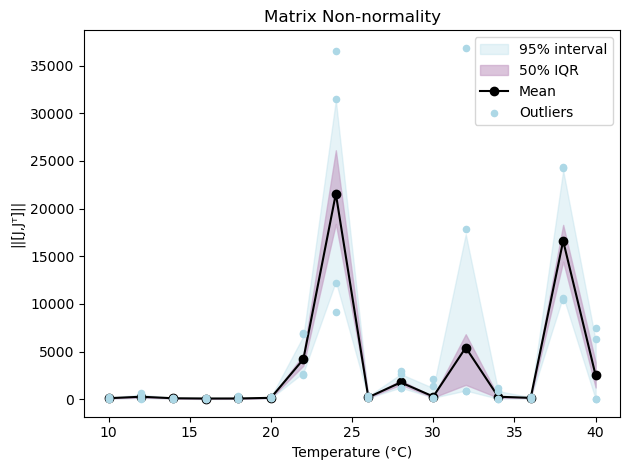

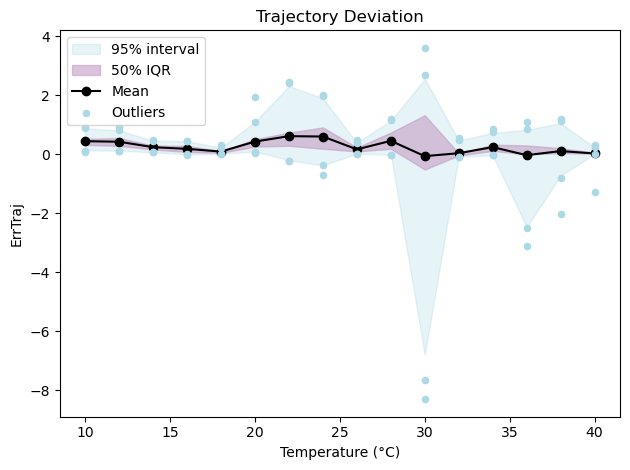

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# ─── 1) Read & clean ─────────────────────────────────────────────────────────
metrics_fp = "output/metrics_N50.csv"
traj_fp    = "output/traj_N50.csv"

df = pd.read_csv(metrics_fp)
for col in ['stab_mi','stab_glv','react_mi','react_glv']:
    if col in df:
        df[col] = (df[col]
            .apply(lambda x: ast.literal_eval(x).real if isinstance(x,str) and '+' in x else x)
            .astype(float)
        )
df['T_C'] = df['T_K'] - 273.15

df_traj = pd.read_csv(traj_fp)
df_traj['T_C'] = df_traj['T_K'] - 273.15

# ─── 2) Stats helper ─────────────────────────────────────────────────────────
def get_stats(series):
    mean = series.mean()
    p25, p75 = series.quantile([0.25,0.75])
    p025, p975 = series.quantile([0.025,0.975])
    return mean, p25, p75, p025, p975

# ─── 3) Single‐series plot helper ────────────────────────────────────────────
def plot_metric(df, col, title, ylabel, hlines=None, hline=None):
    temps = sorted(df['T_C'].unique())
    stats = [get_stats(df[df['T_C']==T][col]) for T in temps]
    mean, p25, p75, lo95, hi95 = zip(*stats)

    # collect outliers
    out_x, out_y = [], []
    for T, (_, _, _, lo, hi) in zip(temps, stats):
        vals = df[df['T_C']==T][col]
        mask = (vals < lo) | (vals > hi)
        out_x += [T]*mask.sum()
        out_y += vals[mask].tolist()

    fig, ax = plt.subplots()
    ax.fill_between(temps, lo95, hi95, color='lightblue', alpha=0.3, label='95% interval')
    ax.fill_between(temps, p25, p75, color='#c49ec4', alpha=0.6, label='50% IQR')
    ax.plot(temps, mean, '-o', color='k', label='Mean')
    if out_x:
        ax.scatter(out_x, out_y, color='lightblue', s=20, label='Outliers', zorder=5)

    # reference lines (decorative only)
    if hline is not None:
        ax.axhline(hline, linestyle=':', color='gray')
    if hlines:
        for y in hlines:
            ax.axhline(y, linestyle=':', color='gray')

    # ensure full data range
    allv = df[col]
    vmin, vmax = allv.min(), allv.max()
    pad = (vmax - vmin) * 0.05 if vmax > vmin else 1
    ax.set_ylim(vmin - pad, vmax + pad)

    ax.set_title(title)
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.tight_layout()

# ─── 4) Two‐series overlay helper ────────────────────────────────────────────
def plot_overlay(df, col1, col2, lab1, lab2, title, ylabel, hlines=None, hline=None):
    temps = sorted(df['T_C'].unique())
    def stats(col):
        q = df.groupby('T_C')[col].quantile([0.5,0.25,0.75,0.025,0.975]).unstack()
        return (q[0.5].values, q[0.25].values, q[0.75].values,
                q[0.025].values, q[0.975].values)

    m1, p25_1, p75_1, lo95_1, hi95_1 = stats(col1)
    m2, p25_2, p75_2, lo95_2, hi95_2 = stats(col2)

    fig, ax = plt.subplots()
    ax.fill_between(temps, lo95_1, hi95_1, color='lightblue', alpha=0.3)
    ax.fill_between(temps, lo95_2, hi95_2, color='#ffa07a', alpha=0.3)
    ax.fill_between(temps, p25_1, p75_1, color='#c49ec4', alpha=0.6)
    ax.fill_between(temps, p25_2, p75_2, color='#ffd700', alpha=0.6)
    ax.plot(temps, m1, '-o', label=lab1, color="#00bfff")
    ax.plot(temps, m2, '-s', label=lab2, color="#ff6347")

    if hline is not None:
        ax.axhline(hline, linestyle=':', color='gray')
    if hlines:
        for y in hlines:
            ax.axhline(y, linestyle=':', color='gray')

    ax.set_title(title)
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.tight_layout()

# ─── 5) Plot everything ──────────────────────────────────────────────────────

plot_metric(df, 'ErrEqAb',
            title='Equilibrium Abundance Error',
            ylabel='Error', hline=0)

plot_metric(df, 'overlap',
            title='Species Overlap',
            ylabel='Number of overlapping species')

plot_metric(df, 'jaccard',
            title='Jaccard Similarity',
            ylabel='Jaccard Index', hline=1.0)

plot_metric(df, 'bray_curtis',
            title='Bray–Curtis Dissimilarity',
            ylabel='Bray–Curtis', hlines=[0,1])

# Shannon Diversity
plot_overlay(df, 'shannon_mi', 'shannon_lv',
             'Shannon MiCRM', 'Shannon GLV',
             title='Shannon Diversity',
             ylabel='Shannon Index')

# Stability
plot_overlay(df, 'stab_mi', 'stab_glv',
             'Stability MiCRM', 'Stability GLV',
             title='Stability (Leading Eigenvalue)',
             ylabel='Leading Eigenvalue')

plot_metric(df, 'abs_stab_err',
            title='Absolute Stability Error',
            ylabel='Error')

# Reactivity
plot_overlay(df, 'react_mi', 'react_glv',
             'Reactivity MiCRM', 'Reactivity GLV',
             title='Reactivity (Hermitian Leading Eigenvalue)',
             ylabel='Leading Hermitian Eigenvalue')

plot_metric(df, 'abs_react_err',
            title='Absolute Reactivity Error',
            ylabel='Error')

plot_metric(df, 'epsilon',
            title='Epsilon (Timescale Separation)',
            ylabel='ε', hline=1.0)

plot_metric(df, 'log10_eps_t_eq',
            title='Log₁₀(ε / t_eq)',
            ylabel='Log10(ε / t_eq)')

# τ_C vs τ_R
plot_overlay(df, 'tau_C', 'tau_R',
             'τ_C', 'τ_R',
             title='Timescale Separation: τ_C vs τ_R',
             ylabel='Timescale')

# Hessian norm
plot_metric(df, 'hessian_norm',
            title='Hessian Frobenius Norm',
            ylabel='||H||')

# Non-normality
plot_metric(df, 'non_normality',
            title='Matrix Non-normality',
            ylabel='||[J,Jᵀ]||')

# Trajectory Deviation
plot_metric(df_traj, 'ErrTraj',
            title='Trajectory Deviation',
            ylabel='ErrTraj')

plt.show()


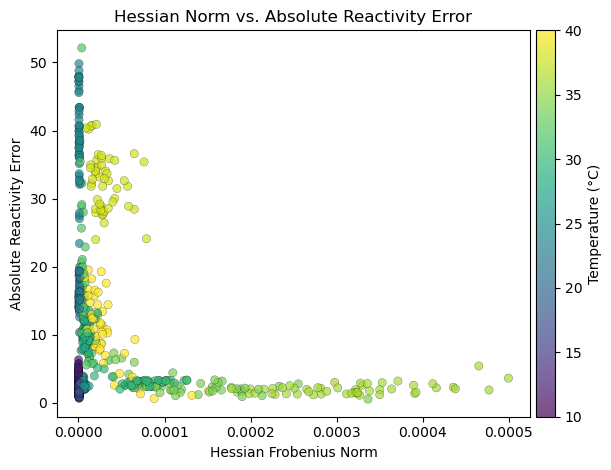

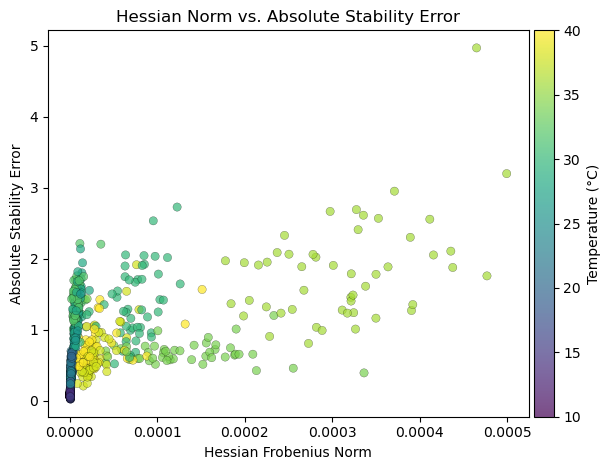

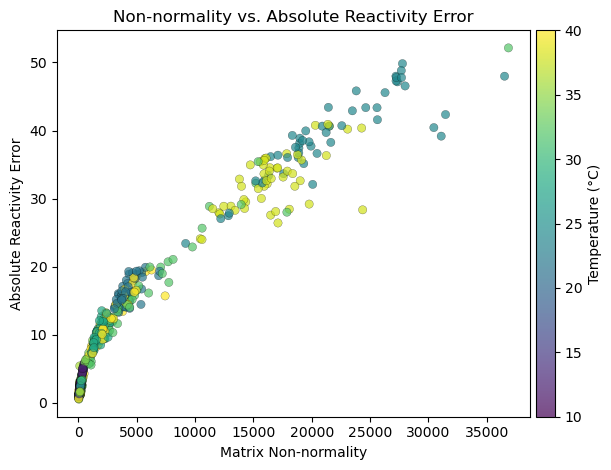

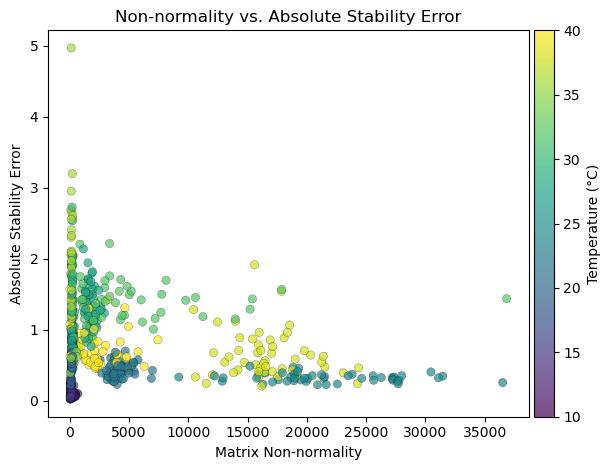

In [17]:
# ─── 6) Relationship plots ───────────────────────────────────────────────────
import matplotlib.pyplot as plt

# Define each pair: (xcol, ycol, x label, y label, title)
pairs = [
    ('hessian_norm',   'abs_react_err',
     'Hessian Frobenius Norm', 'Absolute Reactivity Error',
     'Hessian Norm vs. Absolute Reactivity Error'),
    ('hessian_norm',   'abs_stab_err',
     'Hessian Frobenius Norm', 'Absolute Stability Error',
     'Hessian Norm vs. Absolute Stability Error'),
    ('non_normality',  'abs_react_err',
     'Matrix Non-normality', 'Absolute Reactivity Error',
     'Non-normality vs. Absolute Reactivity Error'),
    ('non_normality',  'abs_stab_err',
     'Matrix Non-normality', 'Absolute Stability Error',
     'Non-normality vs. Absolute Stability Error'),
]

for xcol, ycol, xl, yl, title in pairs:
    fig, ax = plt.subplots()
    sc = ax.scatter(
        df[xcol], df[ycol],
        c=df['T_C'], cmap='viridis',
        alpha=0.7, edgecolor='k', linewidth=0.2
    )
    cbar = plt.colorbar(sc, ax=ax, pad=0.01)
    cbar.set_label('Temperature (°C)')
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.set_title(title)
    fig.tight_layout()

plt.show()


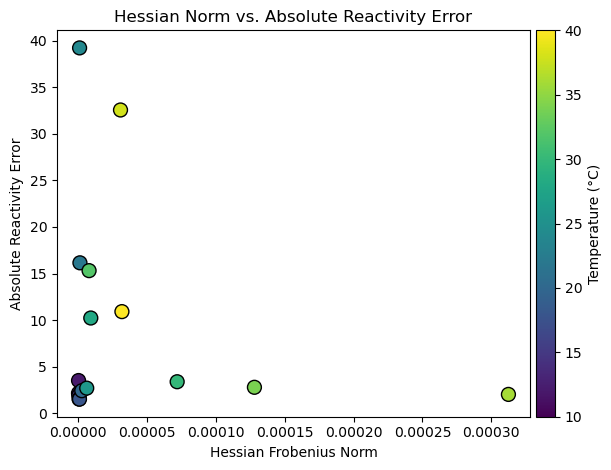

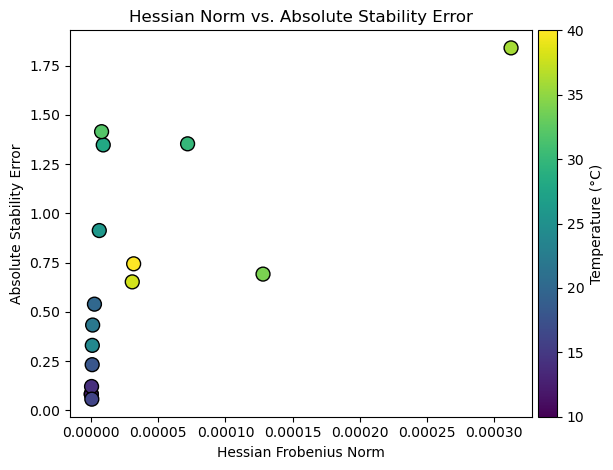

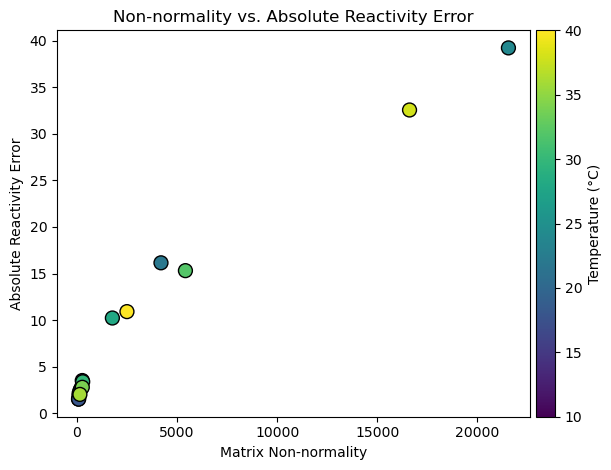

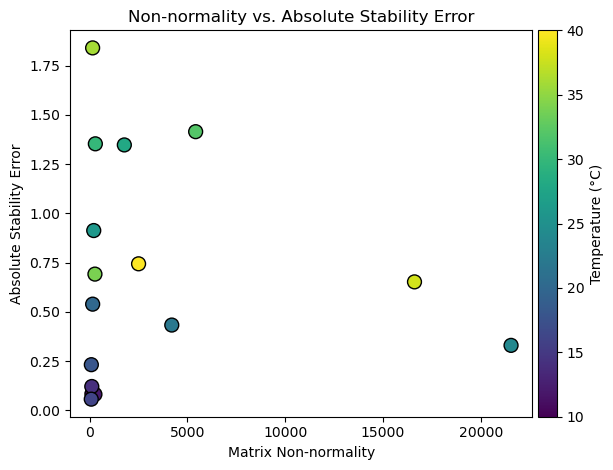

In [19]:
# ─── 6) Relationship plots (mean per temperature) ───────────────────────────
import matplotlib.pyplot as plt

pairs = [
    ('hessian_norm',   'abs_react_err',
     'Hessian Frobenius Norm', 'Absolute Reactivity Error',
     'Hessian Norm vs. Absolute Reactivity Error'),
    ('hessian_norm',   'abs_stab_err',
     'Hessian Frobenius Norm', 'Absolute Stability Error',
     'Hessian Norm vs. Absolute Stability Error'),
    ('non_normality',  'abs_react_err',
     'Matrix Non-normality', 'Absolute Reactivity Error',
     'Non-normality vs. Absolute Reactivity Error'),
    ('non_normality',  'abs_stab_err',
     'Matrix Non-normality', 'Absolute Stability Error',
     'Non-normality vs. Absolute Stability Error'),
]

for xcol, ycol, xl, yl, title in pairs:
    # compute mean per temperature
    df_mean = df.groupby('T_C')[[xcol, ycol]].mean().reset_index()

    fig, ax = plt.subplots()
    sc = ax.scatter(
        df_mean[xcol], df_mean[ycol],
        c=df_mean['T_C'], cmap='viridis',
        s=100, edgecolor='k'
    )
   
    cbar = plt.colorbar(sc, ax=ax, pad=0.01)
    cbar.set_label('Temperature (°C)')

    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.set_title(title)
    fig.tight_layout()

plt.show()
